# Minor Flood Frequency

:::{glue:figure} threshold_counts_days_fig
:align: left
:scale: 50%
:::


In this notebook we will plot two indicators concerning flooding at the Hawaii tide gauges, after first taking a general look at the type of data we are able to plot from the UHSLC. These indicators are based on a 'flooding' threshold, using [relative sea level](https://tidesandcurrents.noaa.gov/sltrends/faq.html). 

Download Files:
[Map](../output/SL_FloodFrequency_map.png) |
[Time Series Plot](../output/SL_FloodFrequency_threshold_counts_days.png) |
[Table](../output/SL_FloodFrequency_percent_change.csv)



## Setup

We first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called "setup."

In [1]:
%run setup.ipynb
data_dir = Path('../data' )
output_dir = Path('../output') 

 ##  Retrieve the Tide Station(s) Data Set(s)

We stored this previously in our data directory as "rsl_hawaii.nc"

In [2]:
# load the data
rsl = xr.open_dataset(data_dir / 'rsl_hawaii.nc')

and we'll save a few variables that will come up later for report generation.

### Set the Datum to MHHW

```{margin} A Note on Datums

The sea level variable in the netcdf file is sea level **relative to the station datum**. For more information on the data processing of this gauge, see the [station metdata](https://uhslc.soest.hawaii.edu/rqds/pacific/doc/qa007b.dmt). 

```

In this example, we will set the datum to MHHW. This can be hard coded, or we can read in the [station datum information](https://uhslc.soest.hawaii.edu/stations/?stn=007#datums) from UHSLC. I'm not going to do this, because there's no elegant way to parse the datum table at the moment as far as I can tell. It's a simple call to the NOAA COOPS API if that's the data source, though. Instead I have a saved datums_007.csv file that we'll call from.

In [3]:
def get_MHHW_uhslc_datums(id, datumname): 
    
    url = 'https://uhslc.soest.hawaii.edu/stations/TIDES_DATUMS/fd/LST/fd'+f'{int(id):03}'+'/datumTable_'+f'{int(id):03}'+'_m.html'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table')
    table = table.find_all('tr')[1:] # skip header row
    table = '<table>' + ''.join([str(x) for x in table]) # add back the table tag
    table_io = io.StringIO(str(table))
    datumtable = pd.read_html(table_io)[0]
    datum = datumtable[datumtable['Datum'] == datumname]['Value'].values[0]
    # ensure datum is a float
    datum = float(datum)
    return datum


In [4]:
# add MHHW to the dataset
rsl['MHHW'] = xr.DataArray([1000*get_MHHW_uhslc_datums(id, 'MHHW') for id in rsl['uhslc_id'].values], dims='record_id', coords={'record_id': rsl['record_id']})

rsl['MHHW'].attrs['units'] = 'mm'
rsl['MHHW'].attrs['long_name'] = 'Mean Higher High Water, rel. to station datum'

In [5]:
rsl = rsl.sortby('lat')

In [6]:
# convert sea level to MHHW
rsl['sea_level_MHHW'] = rsl['sea_level'] - rsl['MHHW']
rsl['sea_level_MHHW'].attrs['units'] = 'mm'
rsl['sea_level_MHHW'].attrs['long_name'] = 'Sea Level, relative to MHHW'

rsl

<xarray.Dataset>
Dimensions:               (time: 1048238, record_id: 11)
Coordinates:
  * time                  (time) datetime64[ns] 1905-01-01T10:00:00.028800 .....
  * record_id             (record_id) int64 52 60 552 548 59 57 547 61 58 14 50
Data variables: (12/13)
    sea_level             (record_id, time) float32 ...
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) <U17 ...
    station_country       (record_id) <U30 ...
    station_country_code  (record_id) float32 ...
    ...                    ...
    gloss_id              (record_id) float32 ...
    ssc_id                (record_id) <U4 ...
    last_rq_date          (record_id) datetime64[ns] ...
    MHHW                  (record_id) float64 1.225e+03 1.912e+03 ... 1.204e+03
    MSL                   (record_id) float64 ...
    sea_level_MHHW        (record_id, time) float64 nan nan nan ... -180.0 -98.0
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2024-08-19T14:27:33Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

###  Assess Station Data Quality for the POR (1983-2022)

To do this, we'll plot all the sea level data to make sure our data looks correct, and then we'll truncate the data set to the time period of record (POR).

```{margin} Watch the units!
```{caution} Note that the sea_level variable here is in millimeters (mm)! If we want to plot things on a centimeter (cm) scale, we have to divide by 10.
```

Text(0, 0.5, 'Sea Level, relative to MHHW (cm, offset by 150cm per station)')

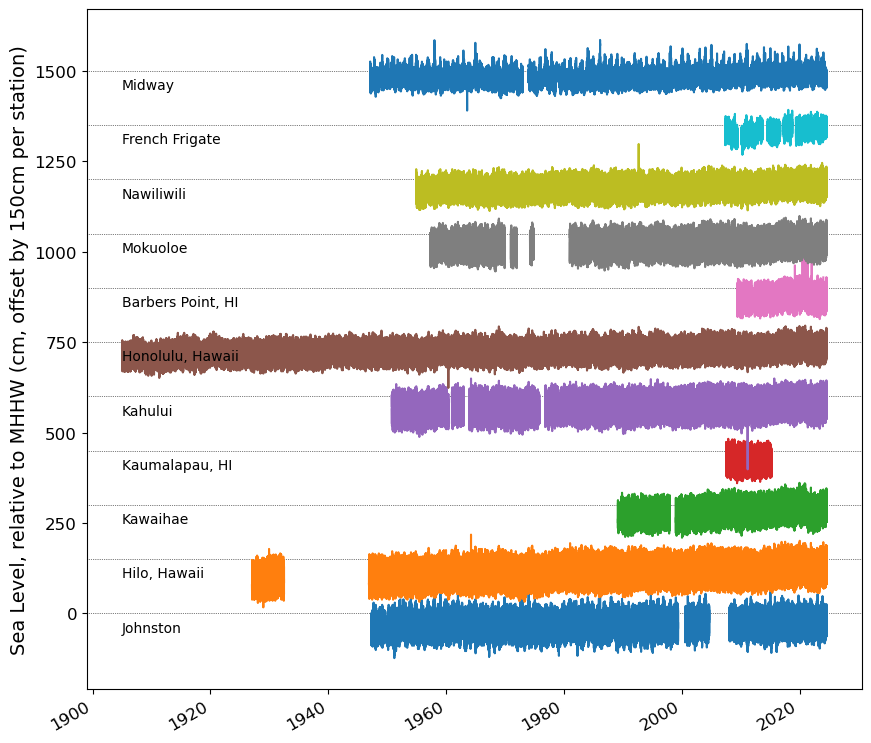

In [7]:
fig, ax = plt.subplots(sharex=True, figsize=(10, 10))
fig.autofmt_xdate()
# ax.plot(rsl.time.values,rsl.sea_level_MHHW.T.values/10)

# ax.set_ylabel(rsl['sea_level_MHHW'].long_name) #divide by 10 to convert to cm

# # add legend to bottom of plot
# ax.legend(rsl['station_name'].values, bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)  


# Initial offset
offset = 0
# The amount to offset each successive line
offset_increment = 150  # Adjust this value based on your data scale and visual preference

for i, record_id in enumerate(rsl['record_id'].values):
    # Extract the series for this station
    sea_level_data = rsl.sea_level_MHHW.isel(record_id=i).values / 10  # Convert to cm
    # Plot, adding the offset
    #add horizontal line for each station
    ax.axhline(offset, color='black', linewidth=0.5, linestyle=':')
    ax.plot(rsl.time.values, sea_level_data + offset, label=rsl['station_name'].values[i])
    ax.text(rsl.time.values[0], offset-20, rsl['station_name'].values[i], color='black', fontsize=10, ha='left', va='top')
    # Increment the offset for the next series
    offset += offset_increment

ax.set_ylabel(rsl['sea_level_MHHW'].long_name + ' (cm, offset by 150cm per station)')




In [8]:
# take only a subset of the data: Hilo, Kawaihae, Kahului, Mokuoloe, Honolulu, Nawiliwili, Johnston and Midway Island
subset = rsl.sel(record_id=[500,520,570,580,590,600,610,5520])

subset = subset.sortby('lat')

fig, ax = plt.subplots(sharex=True, figsize=(10, 10))
fig.autofmt_xdate()
# ax.plot(rsl.time.values,rsl.sea_level_MHHW.T.values/10)
# ax.set_ylabel(rsl['sea_level_MHHW'].long_name) #divide by 10 to convert to cm
# # add legend to bottom of plot
# ax.legend(rsl['station_name'].values, bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)  
# Initial offset
offset = 0
# The amount to offset each successive line
offset_increment = 150  # Adjust this value based on your data scale and visual preference

for i, record_id in enumerate(subset['record_id'].values):
    # Extract the series for this station
    sea_level_data = subset.sea_level_MHHW.isel(record_id=i).values / 10  # Convert to cm
    # Plot, adding the offset
    #add horizontal line for each station
    ax.axhline(offset, color='black', linewidth=0.5, linestyle=':')
    ax.plot(subset.time.values, sea_level_data + offset, label=subset['station_name'].values[i])
    ax.text(subset.time.values[0], offset-20, subset['station_name'].values[i], color='black', fontsize=10, ha='left', va='top')
    # Increment the offset for the next series
    offset += offset_increment

ax.set_ylabel(subset['sea_level_MHHW'].long_name + ' (cm, offset by 150cm per station)')

KeyError: "not all values found in index 'record_id'"

#### Identify epoch for the flood frequency analysis

Now, we'll calculate trend starting from the beginning of the tidal datum analysis period epoch to the last time processed. The  epoch information is given in the datums table. 

In [9]:

# make epoch_start equal to Jan 1 1983 in datetime format
epoch_start = dt.datetime(1983, 1, 1)

# and for now, end time will be the end of 2023
epoch_end = dt.datetime(2023, 12,31)


hourly_data = subset.sel(dict(time=slice(epoch_start, epoch_end)))
hourly_data = hourly_data.sortby('lat')

glue("startEpochDateTime",epoch_start.strftime('%Y-%m-%d'), display=False)
glue("endEpochDateTime",epoch_end.strftime('%Y-%m-%d'), display=False)



and plot the hourly time series

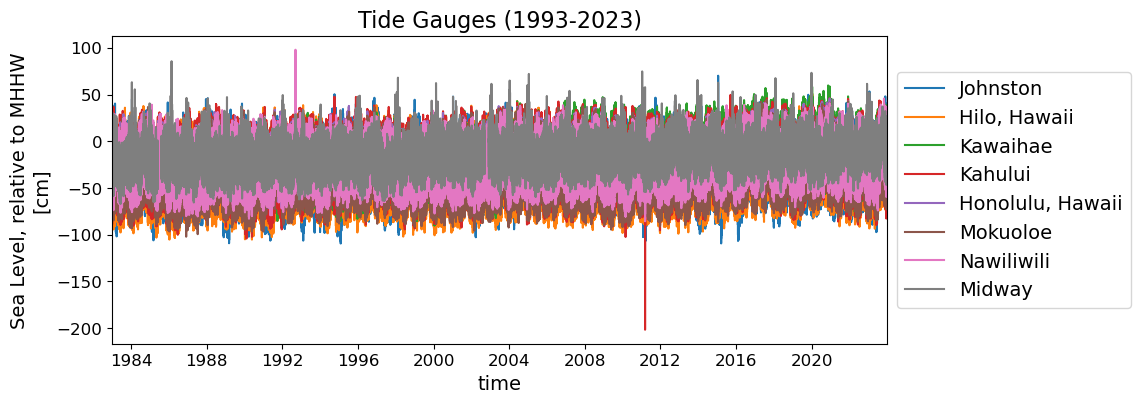

In [10]:
# fig, ax = plt.subplots(sharex=True)
# fig.autofmt_xdate()
# ax.plot(hourly_data.time.values,hourly_data.sea_level_MHHW.T.values/10) #divide by 10 to convert to cm
# 
hourly_data['sea_level_MHHW_cm'] = hourly_data['sea_level_MHHW'] / 10

hourly_data['sea_level_MHHW_cm'].attrs['units'] = 'cm'
hourly_data['sea_level_MHHW_cm'].attrs['long_name'] = 'Sea Level, relative to MHHW'

hourly_data['sea_level_MHHW_cm'].plot.line(x='time',label=hourly_data.station_name.values)

#put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# set xlimits
plt.xlim([epoch_start, epoch_end])

# set title 
plt.title('Tide Gauges (1993-2023)')


glue("TS_full_fig",fig,display=False)


:::{glue:figure} TS_full_fig
:name: "fig-TS_full"

Full time series at the {glue:}`SL_Data_Wrangling.ipynb::station_group` tide gauges for the entire record from {glue:text}`startEpochDateTime` to {glue:text}`endEpochDateTime`. Note that the sea level is plotted in units of cm, relative to {glue:}`SL_Data_Wrangling.ipynb::datumname`.
:::

### Adjust the data from calendar year to storm year

Storm year goes from May-April. Need to consult with Ayesha about this.

In [11]:
#IGNORING FOR NOW, DOES HAWAII DO STORM YEAR?

# hourly_data['day'] = (('time'), hourly_data.time.dt.dayofyear.data)
# hourly_data['month'] = (('time'), hourly_data.time.dt.month.data)    
# hourly_data['year'] = (('time'), hourly_data.time.dt.year.data)

# # adjust year to storm year, where the storm year starts on May 1st
# # if the month is less than 5, subtract a year
# hourly_data['year_storm'] = (('time'), hourly_data.year.data - (hourly_data.month.data < 5))

# hourly_data['year_storm'] = hourly_data['year_storm'].astype(int)

# hourly_data['year_storm'].values

# # get the year_storm value for April 15, 1997
# hourly_data.sel(time='1997-04-15')

### Assign a Threshold
The threshold used here to determine a flood event is 30 cm above MHHW.

In [12]:
threshold = 30 # in cm
glue("threshold",threshold,display=False)

hourly_data

<xarray.Dataset> Size: 60MB
Dimensions:               (time: 359377, record_id: 8)
Coordinates:
  * time                  (time) datetime64[ns] 3MB 1983-01-01 ... 2023-12-31
  * record_id             (record_id) int16 16B 520 600 5520 590 570 610 580 500
Data variables: (12/13)
    sea_level             (record_id, time) float32 12MB ...
    lat                   (record_id) float32 32B ...
    lon                   (record_id) float32 32B ...
    station_name          (record_id) <U17 544B 'Johnston' ... 'Midway'
    station_country       (record_id) <U30 960B ...
    station_country_code  (record_id) float32 32B ...
    ...                    ...
    gloss_id              (record_id) float32 32B ...
    ssc_id                (record_id) <U4 128B ...
    last_rq_date          (record_id) datetime64[ns] 64B ...
    MHHW                  (record_id) float64 64B 1.225e+03 ... 1.204e+03
    sea_level_MHHW        (record_id, time) float64 23MB -920.0 -764.0 ... -36.0
    sea_level_MHHW_cm     (record_id, time) float64 23MB -92.0 -76.4 ... -3.6
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2024-03-07T14:27:49Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [13]:
# Assuming year_storm is created from the 'time' column
hourly_data['year_storm'] = hourly_data['time'].dt.year
hourly_data['year_storm'] = hourly_data['year_storm'].astype(int)

## Calculate and Plot Flood Frequency
To analyze flood frequency, we will look for daily maximum sea levels for each day in our dataset, following {cite:t}`thompson_statistical_2019` and others. Then, we can group our data by year and month to visualize temporal patterns in daily SWL exceedance.   

:::{glue:figure} histogram_fig
:name: "fig-histogram"
:figclass: margin

Histogram of daily maximum water levels at the {glue:}`SL_Data_Wrangling.ipynb::station_group` tide gauges for the entire record from {glue:text}`startEpochDateTime` to {glue:text}`endEpochDateTime`, relative to {glue:}`SL_Data_Wrangling.ipynb::datumname`. The dashed red line indicates the chosen threshold of {glue:text}`threshold` cm.

s

:::{margin}
Note this next code block takes a bit of time. Patience!
:::

In [14]:
# Resample the hourly data to daily maximum sea level
SL_daily_max = hourly_data.resample(time='D').max()
SL_daily_max

<xarray.Dataset> Size: 31MB
Dimensions:               (record_id: 8, time: 14975)
Coordinates:
  * record_id             (record_id) int16 16B 520 600 5520 590 570 610 580 500
  * time                  (time) datetime64[ns] 120kB 1983-01-01 ... 2023-12-31
Data variables: (12/14)
    sea_level             (time, record_id) float32 479kB 1.228e+03 ... 1.168...
    lat                   (time, record_id) float32 479kB 16.75 19.73 ... 28.22
    lon                   (time, record_id) float32 479kB 190.5 204.9 ... 182.6
    station_name          (time, record_id) <U17 8MB 'Johnston' ... 'Midway'
    station_country       (time, record_id) <U30 14MB 'United States of Ameri...
    station_country_code  (time, record_id) float32 479kB 840.0 840.0 ... 840.0
    ...                    ...
    ssc_id                (time, record_id) <U4 2MB 'john' 'hilo' ... 'midx'
    last_rq_date          (time, record_id) datetime64[ns] 958kB 2018-12-31T2...
    MHHW                  (time, record_id) float64 958kB 1.225e+03 ... 1.204...
    sea_level_MHHW        (time, record_id) float64 958kB 3.0 307.0 ... -36.0
    sea_level_MHHW_cm     (time, record_id) float64 958kB 0.3 30.7 ... -3.6
    year_storm            (time) int64 120kB 1983 1983 1983 ... 2023 2023 2023
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2024-03-07T14:27:49Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

Text(0.5, 1.0, 'Sea Level Daily Maximum Time Series')

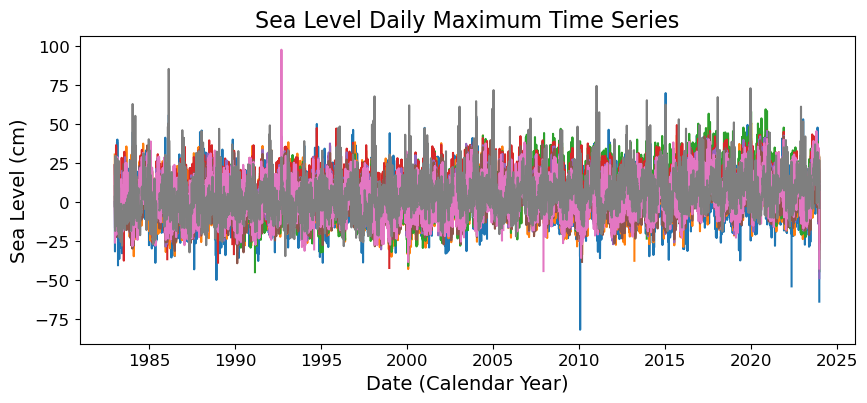

In [15]:
# make a new figure that is 15 x 5
fig, ax = plt.subplots(sharex=True)
plt.plot(SL_daily_max.time.values, SL_daily_max.sea_level_MHHW.values/10)
plt.xlabel('Date (Calendar Year)')
plt.ylabel('Sea Level (cm)')
plt.title('Sea Level Daily Maximum Time Series')

# # add a horizontal line at the threshold
# plt.axhline(threshold, color='r', linestyle='--', label='Threshold')


# # Correcting the threshold to find days when sea_level_MHHW is greater than 300 mm
# days_above_threshold = SL_daily_max.where(SL_daily_max.sea_level_MHHW/10 > threshold, drop=True)

# # Highlighting the days above the threshold for each record_id
# for record_id in days_above_threshold.record_id.values:
#     above_threshold_per_record = days_above_threshold.sea_level_MHHW.sel(record_id=record_id)
#     ax.scatter(above_threshold_per_record.time.values, above_threshold_per_record.values / 10)



In [16]:
sea_level_data_cm = hourly_data['sea_level_MHHW'].values/10 # convert to cm

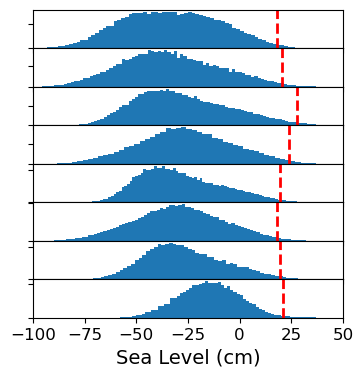

In [17]:
fig, axs = plt.subplots(8, 1, sharex=True, figsize=(4, 4))

for i, ax in enumerate(axs):
    ax.hist(hourly_data['sea_level_MHHW_cm'][i,:], bins=100, density=True, label='Sea Level Data')
    ax.axvline(np.nanpercentile(hourly_data['sea_level_MHHW_cm'][i,:], 99), color='r', linestyle='dashed', linewidth=2, label='97.5th Percentile')

    # remove y-axis label for all
    ax.set_yticklabels('')

axs[-1].set_xlabel('Sea Level (cm)')
plt.subplots_adjust(hspace=0)

# set xlim to -150,75
plt.xlim(-100,50)

threshold_percentile = 99
#make threshold for (XX))th percentile on each gauge
thresholds = np.nanpercentile(hourly_data['sea_level_MHHW_cm'], threshold_percentile, axis=1)
glue("threshold_percentile",threshold_percentile,display=False)


In [18]:
thresholds

array([18.3, 20.6, 27.7, 23.7, 19.5, 18.3, 19.5, 20.8])

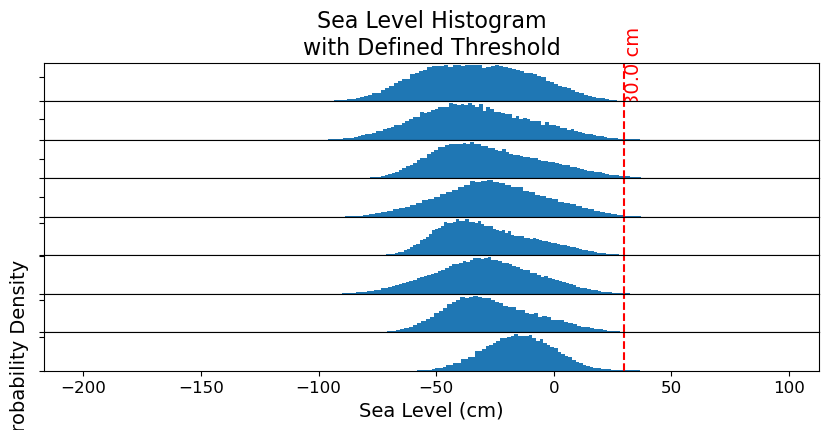

In [19]:
# Make a pdf of the data with 95th percentile threshold
fig, axs = plt.subplots(8, 1, sharex=True)

for i, ax in enumerate(axs):
    ax.hist(hourly_data['sea_level_MHHW_cm'][i,:], bins=100, density=True, label='Sea Level Data')
    ax.axvline(threshold, color='r', linestyle='--', label='Threshold: {:.4f} cm'.format(threshold))

    # remove y-axis label for all
    ax.set_yticklabels('')

axs[-1].set_xlabel('Sea Level (cm)')
plt.subplots_adjust(hspace=0)


ax.set_xlabel('Sea Level (cm)')
ax.set_ylabel('Probability Density')
# make the title two lines
axs[0].set_title('Sea Level Histogram\nwith Defined Threshold')

# add label to dashed line
# get value of middle of y-axis for label placement
ymin, ymax = ax.get_ylim()
yrange = ymax - ymin
y_middle = ymin + yrange/2

axs[0].text(threshold, y_middle, '{:.1f} cm'.format(threshold), rotation=90, va='center', ha='left', color='r')
glue("histogram_fig", fig, display=False)

In [20]:
flood_day = (SL_daily_max.sea_level_MHHW_cm.values > thresholds)
SL_daily_max

flood_hour = (hourly_data.sea_level_MHHW_cm.values > thresholds[:,None])
flood_hour

# flip the array so that the first dimension is time
flood_hour = np.transpose(flood_hour)

In [21]:
# Add the 'flood_day' variable to the dataset
SL_daily_max['flood_day'] = (('time', 'record_id'), flood_day.data)

# Filtering for flood days again now that 'flood_day' has been correctly added
flood_days_data = SL_daily_max.where(SL_daily_max.flood_day, drop=True)

# Initialize an empty DataFrame again for the loop
flood_days_per_year = pd.DataFrame()

for record_id in SL_daily_max.record_id.values:
    # Extracting flood days for each record_id
    flood_days_df = flood_days_data.sel(record_id=record_id).dropna(dim='time', how='all').to_dataframe().reset_index()
    
    # Extract year from the 'time' column and count flood days
    flood_days_df['year'] = flood_days_df['time'].dt.year
    flood_days_count = flood_days_df.groupby('year').size().reset_index(name=record_id)
    
    # Merge this count with the main DataFrame
    if flood_days_per_year.empty:
        flood_days_per_year = flood_days_count.set_index('year')
    else:
        flood_days_per_year = flood_days_per_year.join(flood_days_count.set_index('year'), how='outer')

# Replace missing values with 0
flood_days_per_year.fillna(0, inplace=True)
flood_days_per_year = xr.DataArray(flood_days_per_year.values, dims=('year', 'record_id'), coords={'year': flood_days_per_year.index, 'record_id': flood_days_per_year.columns})

flood_days_per_year

<xarray.DataArray (year: 41, record_id: 8)> Size: 3kB
array([[ 37.,  30.,   0.,  19.,  13.,  16.,  19.,   9.],
       [ 36.,  40.,   0.,  41.,  61.,  51.,  43.,  13.],
       [ 14.,  14.,   0.,  27.,  25.,  24.,  48.,   5.],
       [ 15.,  11.,   0.,   4.,   5.,   3.,   6.,  16.],
       [ 12.,  33.,   0.,  27.,  17.,  13.,   6.,  12.],
       [ 53.,  32.,   0.,  77.,  61.,  59.,  51.,   7.],
       [ 22.,  17.,   3.,   9.,  19.,  20.,  21.,   6.],
       [ 12.,   6.,   1.,   7.,   3.,  10.,  21.,   4.],
       [ 11.,  23.,   3.,  21.,  23.,   8.,  24.,   2.],
       [ 33.,  38.,   0.,  42.,  30.,  37.,  29.,   8.],
       [ 19.,  39.,   3.,  28.,   8.,  17.,  25.,  11.],
       [ 24.,   4.,   0.,  16.,  15.,   9.,  13.,   2.],
       [ 31.,  14.,   2.,  35.,  42.,  35.,  25.,  13.],
       [ 49.,  43.,   3.,  47.,  34.,  34.,  36.,   8.],
       [ 21.,  29.,   1.,  16.,  11.,  14.,  12.,   4.],
       [ 30.,   9.,   0.,   5.,   1.,   4.,   0.,  29.],
       [ 22.,  15.,   4.,  16.,  11.,   8.,  11.,   8.],
       [  4.,   3.,   0.,  13.,   7.,   7.,   6.,  14.],
       [ 44.,  29.,  10.,  33.,  19.,  25.,   7.,  10.],
       [ 27.,  22.,   0.,  15.,   7.,   6.,  10.,   9.],
...
       [ 23.,  91.,  33.,  87.,  76.,  85.,  37.,  27.],
       [  0.,  53.,  13.,  61.,  43.,  42.,  31.,  16.],
       [  0.,  46.,  31.,  79.,  67.,  73.,  63.,  10.],
       [  0.,  45.,  56.,  49.,  43.,  57.,  30.,  12.],
       [ 25.,  36.,  53.,  42.,  44.,  37.,  43.,  18.],
       [  4.,  30.,  30.,  21.,  13.,  15.,  11.,  28.],
       [ 54.,  38.,  48.,  41.,  31.,  38.,  29.,  38.],
       [ 63.,  20.,  32.,  32.,  17.,  21.,  21.,  11.],
       [ 31.,   7.,  12.,  11.,   8.,   8.,  16.,  69.],
       [ 41.,  18.,  30.,  29.,  14.,  17.,  35.,  35.],
       [ 20.,  49.,  49.,  47.,  29.,  35.,  46.,  44.],
       [ 32.,  46.,  63.,  42.,  12.,  15.,  35.,  20.],
       [ 69.,  72.,  82.,  69.,  66.,  62.,  73.,   7.],
       [ 84., 129., 144., 122., 118., 130., 112.,  31.],
       [ 31.,  80.,  92.,  60.,  52.,  50.,  46.,  31.],
       [ 36.,  98., 123.,  84.,  81.,  72.,  73.,  39.],
       [ 47., 140., 163., 147., 173., 155.,  98.,   8.],
       [ 58.,  52.,  45.,  53.,  74.,  54.,  67.,  46.],
       [ 32.,  43.,  15.,  51.,  44.,  31.,  62.,  55.],
       [ 67.,  72.,  54.,  77.,  69.,  72., 126.,  58.]])
Coordinates:
  * year       (year) int32 164B 1983 1984 1985 1986 ... 2020 2021 2022 2023
  * record_id  (record_id) int64 64B 520 600 5520 590 570 610 580 500

In [22]:
# Add the 'flood_day' variable to the dataset
hourly_data['flood_hour'] = (('time', 'record_id'), flood_hour.data)
# Filtering for flood days again now that 'flood_hour' has been correctly added
flood_hours_data = hourly_data.where(hourly_data.flood_hour, drop=True)
# Initialize an empty DataFrame again for the loop
flood_hours_per_year = pd.DataFrame()
for record_id in hourly_data.record_id.values:
    # Extracting flood days for each record_id
    flood_hours_df = flood_hours_data.sel(record_id=record_id).dropna(dim='time', how='all').to_dataframe().reset_index()
  
    # Extract year from the 'time' column and count flood days
    flood_hours_df['year'] = flood_hours_df['time'].dt.year
    flood_hours_count = flood_hours_df.groupby('year').size().reset_index(name=record_id)
  
    # Merge this count with the main DataFrame
    if flood_hours_per_year.empty:
        flood_hours_per_year = flood_hours_count.set_index('year')
    else:
        flood_hours_per_year = flood_hours_per_year.join(flood_hours_count.set_index('year'), how='outer')
# Replace missing values with 0
flood_hours_per_year.fillna(0, inplace=True)
flood_hours_per_year = xr.DataArray(flood_hours_per_year.values, dims=('year', 'record_id'), coords={'year': flood_hours_per_year.index, 'record_id': flood_hours_per_year.columns})


In [23]:
#make new xarray dataset with attributes from SL_daily_max
ds = xr.Dataset()

ds['flood_hours_per_year'] = (('year', 'record_id'), flood_hours_per_year.values)

ds['flood_days_per_year'] = (('year', 'record_id'), flood_days_per_year.values)

ds['flood_days_per_year'].attrs = {'long_name': 'Number of flood days per year', 'units': 'days'}
ds['flood_hours_per_year'].attrs = {'long_name': 'Number of flood hours per year', 'units': 'hours'}

# set year and record_id as coordinates
ds['year'] = flood_hours_per_year.year
ds['record_id'] = flood_hours_per_year.record_id

ds['year'].attrs = {'long_name': 'Year', 'units': 'calendar year'}
ds['record_id'].attrs = {'long_name': 'Record ID', 'units': '1'}


ds['lat'] = SL_daily_max['lat'].isel(time=0)
ds['lat'].attrs = {'long_name': 'Latitude', 'units': 'degrees_north'}

ds['lon'] = SL_daily_max['lon'].isel(time=0)
ds['lon'].attrs = {'long_name': 'Longitude', 'units': 'degrees_east'}

ds['station_name'] = SL_daily_max['station_name'].isel(time=0)
ds['station_name'].attrs = {'long_name': 'Station Name', 'units': '1'}

ds['station_country'] = SL_daily_max['station_country'].isel(time=0)
ds['station_country'].attrs = {'long_name': 'Station Country', 'units': '1'}

#remove time as coordinate
ds = ds.reset_coords('time', drop=True)

ds



<xarray.Dataset> Size: 7kB
Dimensions:               (year: 41, record_id: 8)
Coordinates:
  * year                  (year) int32 164B 1983 1984 1985 ... 2021 2022 2023
  * record_id             (record_id) int16 16B 520 600 5520 590 570 610 580 500
Data variables:
    flood_hours_per_year  (year, record_id) float64 3kB 71.0 56.0 ... 221.0
    flood_days_per_year   (year, record_id) float64 3kB 37.0 30.0 ... 126.0 58.0
    lat                   (record_id) float32 32B 16.75 19.73 ... 21.97 28.22
    lon                   (record_id) float32 32B 190.5 204.9 ... 200.6 182.6
    station_name          (record_id) <U17 544B 'Johnston' ... 'Midway'
    station_country       (record_id) <U30 960B 'United States of America (th...

In [24]:
#find minimum value in flood_days_per_year
min_flood_days = flood_days_per_year.min().min()
max_flood_days = flood_days_per_year.max().max()


### Plot Flood Frequency Counts 

The flood frequency counts are defined as the number of time periods that exceed a given threshold within a year. This plot follows {cite:t}`center_for_operational_oceanographic_products_and_services_us_sea_2014`.

In [25]:
# result = station_name + ' above ' + str(threshold)
# print(result)
# station_name
# station_name + 'hello'



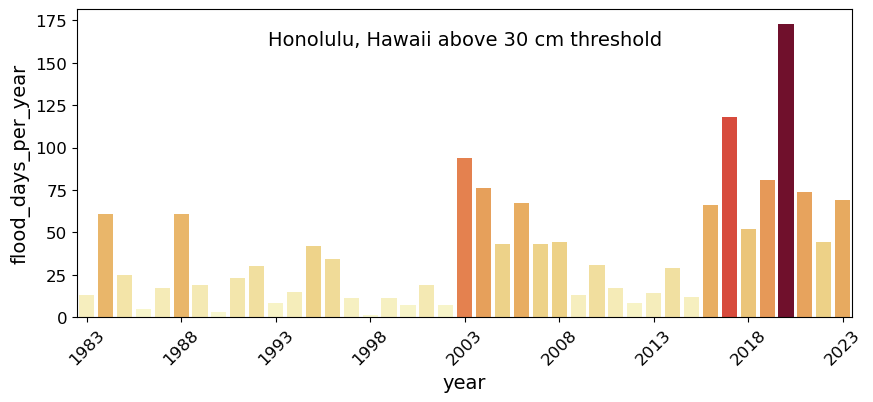

In [26]:
# Adjusting the heatmap palette to improve readability
adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)

rid = 570
df = ds['flood_days_per_year'].sel(record_id=rid).to_dataframe().reset_index()

norm = plt.Normalize(df['flood_days_per_year'].min(), df['flood_days_per_year'].max())
colors = [adjusted_heatmap_palette(norm(value)) for value in df['flood_days_per_year']]


# Plotting with the adjusted settings
fig, ax = plt.subplots()


ax = sns.barplot(
    x='year', 
    y='flood_days_per_year', 
    hue='year', 
    data=df,
    palette=colors,
    dodge=False,
    legend=False
)
ax.set_xticks(range(0, len(df), 5))  # Setting x-ticks to show every 5th year
year_ticks = df['year'][::5].astype(int)  # Selecting every 5th year for the x-axis
ax.set_xticklabels(year_ticks, rotation=45)

# Adding a light gray grid
station_name = ds['station_name'].sel(record_id=rid).values.item()

ax.text(0.5, 0.9, station_name + ' above ' + str(threshold) + ' cm threshold', ha='center', va='center', transform=ax.transAxes)

#save the figure
figname = 'SL_FloodFrequency_threshold_counts_'+station_name+'.png'
fig.savefig(output_dir / figname, bbox_inches='tight')

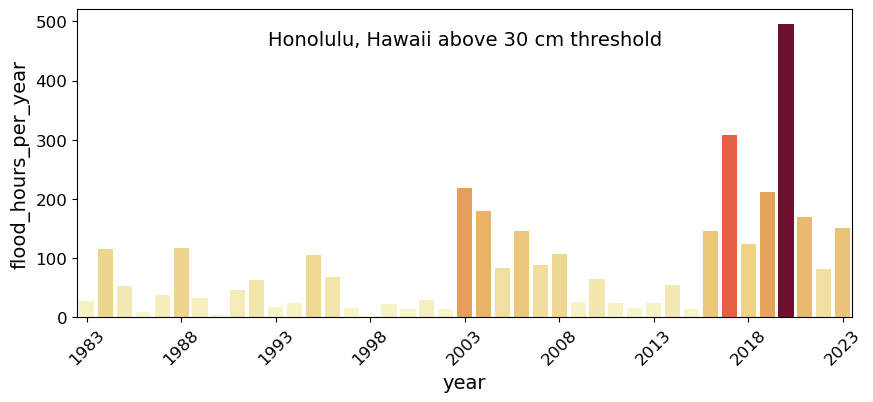

In [27]:
# Adjusting the heatmap palette to improve readability
adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)

rid = 570
df = ds['flood_hours_per_year'].sel(record_id=rid).to_dataframe().reset_index()

norm = plt.Normalize(df['flood_hours_per_year'].min(), df['flood_hours_per_year'].max())
colors = [adjusted_heatmap_palette(norm(value)) for value in df['flood_hours_per_year']]


# Plotting with the adjusted settings
fig, ax = plt.subplots()


ax = sns.barplot(
    x='year', 
    y='flood_hours_per_year', 
    hue='year', 
    data=df,
    palette=colors,
    dodge=False,
    legend=False
)
ax.set_xticks(range(0, len(df), 5))  # Setting x-ticks to show every 5th year
year_ticks = df['year'][::5].astype(int)  # Selecting every 5th year for the x-axis
ax.set_xticklabels(year_ticks, rotation=45)

# Adding a light gray grid
station_name = ds['station_name'].sel(record_id=rid).values.item()

ax.text(0.5, 0.9, station_name + ' above ' + str(threshold) + ' cm threshold', ha='center', va='center', transform=ax.transAxes)

#save the figure
figname = 'SL_FloodFrequency_threshold_counts_HOURS_'+station_name+'.png'
fig.savefig(output_dir / figname, bbox_inches='tight')

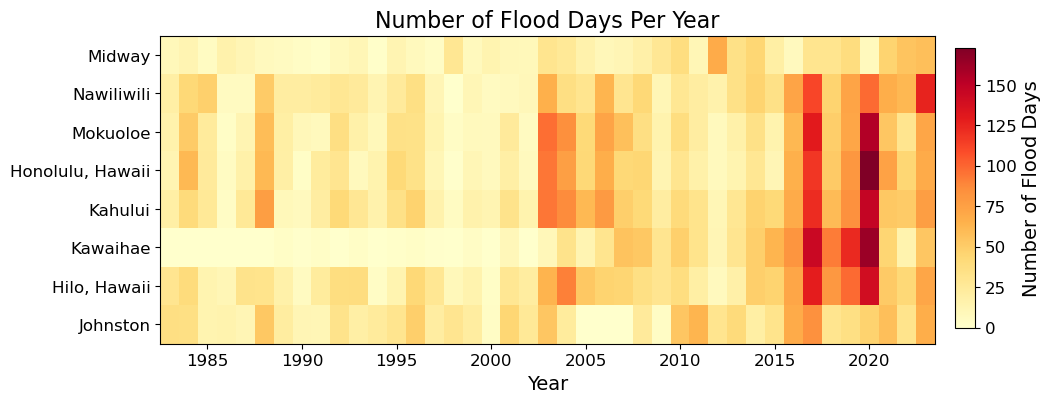

In [28]:
# Adjusting the heatmap palette to improve readability
adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)
norm = plt.Normalize(flood_days_per_year.min().min(), flood_days_per_year.max().max())
colors = [adjusted_heatmap_palette(norm(value)) for value in flood_days_per_year.values]

# do a pcolormesh plot
fig, ax = plt.subplots()
ax.pcolormesh(ds['year'], ds['station_name'], ds['flood_days_per_year'].T, cmap=adjusted_heatmap_palette, norm=norm)

# add a colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # adjust the position and size of the colorbar
sm = plt.cm.ScalarMappable(cmap=adjusted_heatmap_palette, norm=norm)
plt.colorbar(sm, cax=cax,label= 'Number of Flood Days')

ax.set_xlabel('Year')
ax.set_title('Number of Flood Days Per Year')             

glue("threshold_counts_days_fig", fig, display=False)

# save the figure
fig.savefig(output_dir / 'SL_FloodFrequency_threshold_counts_days.png', bbox_inches='tight')

```{glue:figure} threshold_counts_days_fig
:name: "fig-threshold_counts"

Flood frequency counts above {glue:text}`threshold_percentile:.3f`th percentile threshold per year at {glue:}`SL_Data_Wrangling.ipynb::station_group` tide gauges from {glue:text}`startEpochDateTime` to {glue:text}`endEpochDateTime`. 
```

### Plot Flood Duration

This next plot examines the average duration of flooding events as defined by the threshold. 
I have a few issues with this plot being "duration," as it's just counts of hours above the threshold. These hours need not be continuous...which to me is what duration is all about. Anyway, we carry on.

```{margin}
There are some dissimilarities here that give me pause. Going to look into it.
```

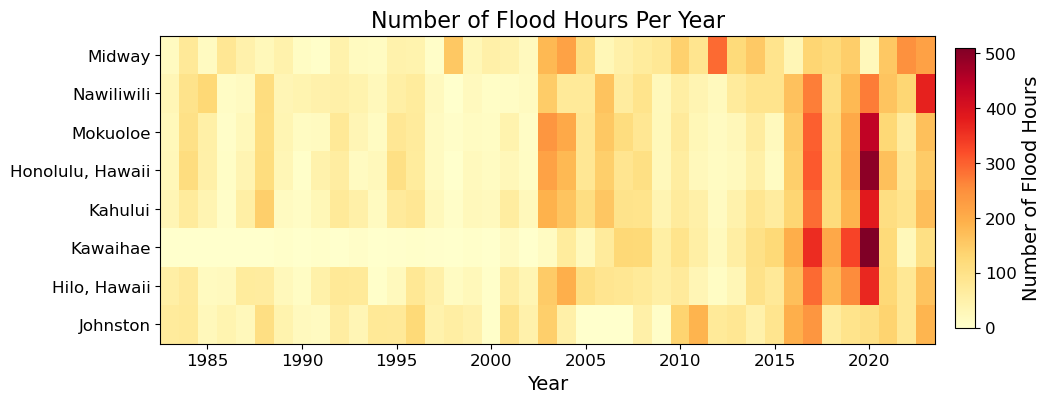

In [29]:
# Adjusting the heatmap palette to improve readability
adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)
norm = plt.Normalize(flood_hours_per_year.min().min(), flood_hours_per_year.max().max())
colors = [adjusted_heatmap_palette(norm(value)) for value in flood_hours_per_year.values]

# do a pcolormesh plot
fig, ax = plt.subplots()
ax.pcolormesh(ds['year'], ds['station_name'], ds['flood_hours_per_year'].T, cmap=adjusted_heatmap_palette, norm=norm)

# add a colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # adjust the position and size of the colorbar
sm = plt.cm.ScalarMappable(cmap=adjusted_heatmap_palette, norm=norm)
plt.colorbar(sm, cax=cax,label= 'Number of Flood Hours')

ax.set_xlabel('Year')
ax.set_title('Number of Flood Hours Per Year')             
# ax.set_yticklabels(SL_daily_max['station_name'].values[0])

# save the figure
fig.savefig(output_dir / 'SL_FloodFrequency_threshold_counts_hours.png', bbox_inches='tight')



glue("duration_fig", fig, display=False)

```{glue:figure} duration_fig
:name: "fig-duration"

Average flood duration in hours above a threshold of {glue:text}`threshold:.0f` cm per year for {glue:}`SL_Data_Wrangling.ipynb::station_group` region tide gauges from {glue:text}`startEpochDateTime` to {glue:text}`endEpochDateTime`. 
```

## Calculate the percent change over time

Next we'll calculate the percent change over the POR at the tide station/s, for both Frequency and Duration.

The next code cell fits a trend line to the flood days per year data and calculates the trend line.
It then plots the data and the trend line in a figure, and calculates the percent change in flood days per year using the trend line. The same process is repeated for flood hours per year.


In [30]:

def calculate_flood_trend(ds, timescale = 'days'):

    if timescale == 'days':
        dsvar = 'flood_days_per_year'
    elif timescale == 'hours':
        dsvar = 'flood_hours_per_year'

    slopes = []
    intercepts = []
    percent_changes = []
    
    #trends is an empty array the length of ds['year'] and the number of records
    trends = np.empty((len(ds['year']), len(ds['record_id'])))

    for record_id in range(len(ds['record_id'])):
        slope, intercept, _, _, _ = stats.linregress(ds['year'].values, ds[dsvar].isel(record_id=record_id).values)
        trend = intercept + slope * ds['year']
        if trend[0] <= 0:
            percent_change = trend[-1:]*100 #this needs help, how to define percent change when the first value is less than 0?
        else:
            percent_change = (trend[-1:] - trend[0]) / trend[0] * 100

        slopes.append(slope)
        intercepts.append(intercept)
        percent_changes.append(percent_change)
        trends[:, record_id] = trend

    return slopes, intercepts, percent_changes, trends

slopes, intercepts, percent_changes, trends = calculate_flood_trend(ds, 'days')

#add to dataset
ds['slope_days'] = (('record_id'), slopes)
ds['intercept_days'] = (('record_id'), intercepts)
ds['percent_change_days'] = (('record_id'), np.squeeze(percent_changes))
ds['trend_days'] = (('year', 'record_id'), trends)

ds['slope_days'].attrs = {'long_name': 'Slope of the trend line', 'units': 'days/year'}
ds['intercept_days'].attrs = {'long_name': 'Intercept of the trend line', 'units': 'days'}
ds['percent_change_days'].attrs = {'long_name': 'Percent change in flood days per year', 'units': '%'}
ds['trend_days'].attrs = {'long_name': 'Trend line of flood days per year', 'units': 'days'}


slopes, intercepts, percent_changes, trends = calculate_flood_trend(ds, 'hours')

#add to dataset
ds['slope_hours'] = (('record_id'), slopes)
ds['intercept_hours'] = (('record_id'), intercepts)
ds['percent_change_hours'] = (('record_id'), np.squeeze(percent_changes))
ds['trend_hours'] = (('year', 'record_id'), trends)

ds['slope_hours'].attrs = {'long_name': 'Slope of the trend line', 'units': 'hours/year'}
ds['intercept_hours'].attrs = {'long_name': 'Intercept of the trend line', 'units': 'hours'}
ds['percent_change_hours'].attrs = {'long_name': 'Percent change in flood hours per year', 'units': '%'}
ds['trend_hours'].attrs = {'long_name': 'Trend line of flood hours per year', 'units': 'hours'}

ds


<xarray.Dataset> Size: 13kB
Dimensions:               (year: 41, record_id: 8)
Coordinates:
  * year                  (year) int32 164B 1983 1984 1985 ... 2021 2022 2023
  * record_id             (record_id) int16 16B 520 600 5520 590 570 610 580 500
Data variables: (12/14)
    flood_hours_per_year  (year, record_id) float64 3kB 71.0 56.0 ... 221.0
    flood_days_per_year   (year, record_id) float64 3kB 37.0 30.0 ... 126.0 58.0
    lat                   (record_id) float32 32B 16.75 19.73 ... 21.97 28.22
    lon                   (record_id) float32 32B 190.5 204.9 ... 200.6 182.6
    station_name          (record_id) <U17 544B 'Johnston' ... 'Midway'
    station_country       (record_id) <U30 960B 'United States of America (th...
    ...                    ...
    percent_change_days   (record_id) float64 64B 151.8 567.1 ... 2.452e+03
    trend_days            (year, record_id) float64 3kB 17.85 10.68 ... 38.68
    slope_hours           (record_id) float64 64B 2.194 3.795 ... 3.883 3.555
    intercept_hours       (record_id) float64 64B -4.318e+03 ... -7.035e+03
    percent_change_hours  (record_id) float64 64B 278.6 1.368e+03 ... 953.2
    trend_hours           (year, record_id) float64 3kB 31.49 11.09 ... 157.1

### Plot time series of all stations

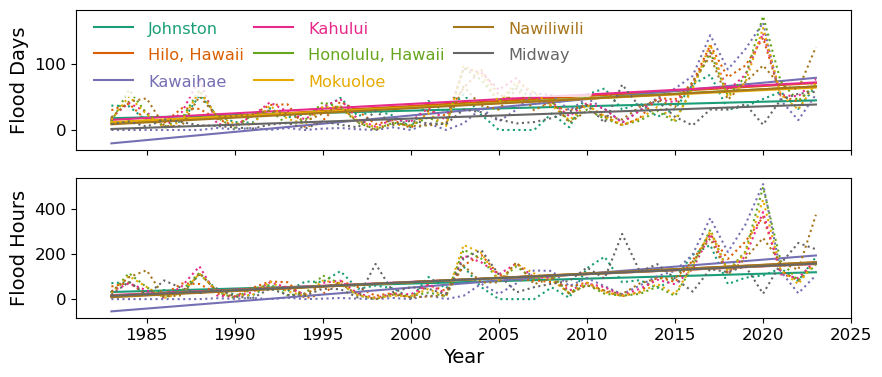

In [31]:
fig, axs = plt.subplots(2,1)

# Set the color for each station
colors = sns.color_palette('Dark2', n_colors=len(ds['record_id']))

# Plot the data for each station with the same color
for i, record_id in enumerate(ds['record_id']):
    axs[0].plot(ds['year'], ds['flood_days_per_year'].sel(record_id=record_id), label=None, color=colors[i], linestyle=':')
    axs[1].plot(ds['year'], ds['flood_hours_per_year'].sel(record_id=record_id), label=None, color=colors[i], linestyle=':')

    # Plot the trend lines
    axs[0].plot(ds['year'], ds['trend_days'].sel(record_id=record_id), label=None , color=colors[i])
    axs[1].plot(ds['year'], ds['trend_hours'].sel(record_id=record_id), label=ds['station_name'].sel(record_id=record_id).values, color=colors[i])

# Set the labels and tick labels
axs[0].set_ylabel('Flood Days')
axs[0].set_xticklabels([])

axs[1].set_xlabel('Year')
axs[1].set_ylabel('Flood Hours')

# add a legend 
axs[1].legend(ncol=3, columnspacing=0.5, bbox_to_anchor=(0, 2.25), loc='upper left')

#color the legend text the same as the lines and then remove the lines
for i, record_id in enumerate(ds['record_id']):
    axs[1].get_legend().get_texts()[i].set_color(colors[i])
    axs[1].get_legend().get_texts()[i].set_fontsize('small')
    # axs[1].get_legend().get_lines()[i].set_linewidth(0)

#remove box around legend
axs[1].get_legend().get_frame().set_linewidth(0.0)    


### Create a Table
Now we'll generate a table with this information, which will be saved as a .csv in the output directory specified at the top of this notebook.

In [32]:
ds

<xarray.Dataset> Size: 13kB
Dimensions:               (year: 41, record_id: 8)
Coordinates:
  * year                  (year) int32 164B 1983 1984 1985 ... 2021 2022 2023
  * record_id             (record_id) int16 16B 520 600 5520 590 570 610 580 500
Data variables: (12/14)
    flood_hours_per_year  (year, record_id) float64 3kB 71.0 56.0 ... 221.0
    flood_days_per_year   (year, record_id) float64 3kB 37.0 30.0 ... 126.0 58.0
    lat                   (record_id) float32 32B 16.75 19.73 ... 21.97 28.22
    lon                   (record_id) float32 32B 190.5 204.9 ... 200.6 182.6
    station_name          (record_id) <U17 544B 'Johnston' ... 'Midway'
    station_country       (record_id) <U30 960B 'United States of America (th...
    ...                    ...
    percent_change_days   (record_id) float64 64B 151.8 567.1 ... 2.452e+03
    trend_days            (year, record_id) float64 3kB 17.85 10.68 ... 38.68
    slope_hours           (record_id) float64 64B 2.194 3.795 ... 3.883 3.555
    intercept_hours       (record_id) float64 64B -4.318e+03 ... -7.035e+03
    percent_change_hours  (record_id) float64 64B 278.6 1.368e+03 ... 953.2
    trend_hours           (year, record_id) float64 3kB 31.49 11.09 ... 157.1

In [33]:
import pandas as pd
# make a dataframe with the percent change in flood days and hours per year, with given threshold
percent_change_df = pd.DataFrame({'percent_change_days': ds['percent_change_days'].values, 'percent_change_hours': ds['percent_change_hours'].values, 'threshold': thresholds})

# add the station name and country
percent_change_df['station'] = ds['station_name'].values
percent_change_df['country'] = ds['station_country'].values

# reorder the columns
percent_change_df = percent_change_df[['station', 'country', 'threshold', 'percent_change_days', 'percent_change_hours']]

# Define your attributes
attributes = {
    'station': 'Station name',
    'country': 'Country name',
    'threshold': 'Threshold in cm above MHHW',
    'percent_change_days': 'Percent change in flood days per year',
    'percent_change_hours': 'Percent change in flood hours per year'
}

# Open the file in write mode
with open(output_dir / 'SL_FloodFrequency_percent_change.csv', 'w') as f:
    # Write the attributes as comments
    for column, attribute in attributes.items():
        f.write(f'# {column}: {attribute}\n')

    # Write the DataFrame to the file
    percent_change_df.to_csv(f, index=False)

percent_change_df  


,station,country,threshold,percent_change_days,percent_change_hours
0,Johnston,United States of America (the),18.3,151.776650,278.592765
1,"Hilo, Hawaii",United States of America (the),20.6,567.123288,1368.404523
2,Kawaihae,United States of America (the),27.7,7926.132404,19354.355401
3,Kahului,United States of America (the),23.7,371.584451,764.890525
4,"Honolulu, Hawaii",United States of America (the),19.5,503.115067,1153.753754
5,Mokuoloe,United States of America (the),18.3,439.929947,976.160843
6,Nawiliwili,United States of America (the),19.5,665.054414,1832.387998
7,Midway,United States of America (the),20.8,2451.954023,953.152732


In [34]:
#make a pretty pdf of the table with great_tables
from great_tables import GT, html

# Create a Table object
table = GT(percent_change_df[["station","threshold","percent_change_days","percent_change_hours"]]).cols_label(
    station=html('Station'), threshold=html('Threshold<br> (cm above MHHW)'), 
    percent_change_days=html('Change in <br>Flood Days (%)'), 
    percent_change_hours=html('Change in <br>Flood Hours (%)')).fmt_number(
        columns=["percent_change_days", "percent_change_hours"], decimals=1)

table

Station,Threshold (cm above MHHW),Change in Flood Days (%),Change in Flood Hours (%)
Johnston,18.3,151.8,278.6
"Hilo, Hawaii",20.6,567.1,"1,368.4"
Kawaihae,27.7,"7,926.1","19,354.4"
Kahului,23.7,371.6,764.9
"Honolulu, Hawaii",19.5,503.1,"1,153.8"
Mokuoloe,18.3,439.9,976.2
Nawiliwili,19.5,665.1,"1,832.4"
Midway,20.8,"2,452.0",953.2


The following cell defines a function that creates a "zebra stripe" pattern for the map borders.

In [35]:
def add_zebra_frame(ax, lw=2, segment_length=0.5, crs=ccrs.PlateCarree()):
    # Get the current extent of the map
    left, right, bot, top = ax.get_extent(crs=crs)

    # Calculate the nearest 0 or 0.5 degree mark within the current extent
    left_start = left - left % segment_length
    bot_start = bot - bot % segment_length

    # Adjust the start if it does not align with the desired segment start
    if left % segment_length >= segment_length / 2:
        left_start += segment_length
    if bot % segment_length >= segment_length / 2:
        bot_start += segment_length

    # Extend the frame slightly beyond the map extent to ensure full coverage
    right_end = right + (segment_length - right % segment_length)
    top_end = top + (segment_length - top % segment_length)

    # Calculate the number of segments needed for each side
    num_segments_x = int(np.ceil((right_end - left_start) / segment_length))
    num_segments_y = int(np.ceil((top_end - bot_start) / segment_length))

    # Draw horizontal stripes at the top and bottom
    for i in range(num_segments_x):
        color = 'black' if (left_start + i * segment_length) % (2 * segment_length) == 0 else 'white'
        start_x = left_start + i * segment_length
        end_x = start_x + segment_length
        ax.hlines([bot, top], start_x, end_x, colors=color, linewidth=lw, transform=crs)

    # Draw vertical stripes on the left and right
    for j in range(num_segments_y):
        color = 'black' if (bot_start + j * segment_length) % (2 * segment_length) == 0 else 'white'
        start_y = bot_start + j * segment_length
        end_y = start_y + segment_length
        ax.vlines([left, right], start_y, end_y, colors=color, linewidth=lw, transform=crs)

The following cell defines a function to implement the zebra stripes on a given axis.

In [36]:
def plot_zebra_frame(ax, lw=5, segment_length=2, crs=ccrs.PlateCarree()):
    """
    Plot a zebra frame on the given axes.

    Parameters:
    - ax: The axes object on which to plot the zebra frame.
    - lw: The line width of the zebra frame. Default is 5.
    - segment_length: The length of each segment in the zebra frame. Default is 2.
    - crs: The coordinate reference system of the axes. Default is ccrs.PlateCarree().
    """
    # Call the function to add the zebra frame
    add_zebra_frame(ax=ax, lw=lw, segment_length=segment_length, crs=crs)
    # add map grid
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    #remove labels from top and right axes
    gl.top_labels = False
    gl.right_labels = False

The following cell defines a function to add arrow icons denoting percent change.

In [37]:
# make a function for adding the arrows
def add_arrow(ax, lat,lon,percent_change,crs, vmin, vmax):
# make colormap of percent change
    adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)

    # Prepare data for quiver plot
    U = np.zeros_like(lon)  # Dummy U component (no horizontal movement)
    V = percent_change/100   # V component scaled by percent change
    arrow_scale = 0.2  # Adjust as necessary for arrow size
    arrow_width = 0.01  # Adjust for desired arrow thickness

    # Quiver plot
    q = ax.quiver(lon,lat, U, V, transform=crs, scale=arrow_scale,
              color=adjusted_heatmap_palette(percent_change.values), 
              cmap=adjusted_heatmap_palette, clim=(vmin, vmax), width=arrow_width)

And here is our final plotting code:

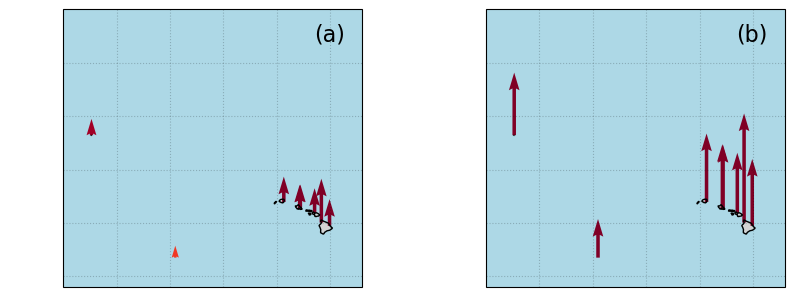

In [38]:
xlims = [-185,-152]
ylims = [14,40]

#fig, ax, crs,cmap = plot_map(vmin,vmax,xlims,ylims)
crs = ccrs.PlateCarree()
fig, axs = plt.subplots(1, 2, figsize=(10, 6),subplot_kw={'projection': crs})

#convert subset['lon'] to negative from 360
subset['lon_west'] = -(360-subset['lon'])


for i, ax in enumerate(axs):
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.coastlines()

     # Fill in water
    ax.add_feature(cfeature.LAND, color='lightgrey')
    
 # add a) b) labels
    ax.text(0.95, 0.95, f'({chr(97 + i)})', 
         horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,
         fontsize=16)

    ax.add_feature(cfeature.OCEAN, color='lightblue')

    # add map grid
    gl = ax.gridlines(draw_labels=False, linestyle=':', color='black',
                  alpha=0.2,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
  
    #remove labels from top and right axes
    gl.top_labels = False
    gl.right_labels = False

    if ax == axs[1]:
        gl.left_labels = False

add_arrow(axs[0], subset['lat'], subset['lon_west'], ds['slope_days'], crs, ds['slope_days'].min().values, ds['slope_days'].max().values)
add_arrow(axs[1], subset['lat'], subset['lon_west'], ds['slope_hours'], crs, ds['slope_hours'].min().values, ds['slope_hours'].max().values)

# Plot zebra frame
#plot_zebra_frame(axs[0], lw=5, segment_length=2, crs=crs)
#plot_zebra_frame(axs[1], lw=5, segment_length=2, crs=crs)

## Add text for percent change
#for i in range(len(subset['lon'])):
#    if ds['percent_change_hours'].values[i] <200:
        #axs[0].text(subset['lon'][i], subset['lat'][i], '{:.1f}'.format(ds['slope_days'].values[i]),
                    #color=adjusted_heatmap_palette(ds['slope_days'].values[i] / vmax))
        #axs[1].text(subset['lon_west'][i]+0.25, subset['lat'][i]+0.5 , '{:.1f}'.format(ds['slope_hours'].values[i]), fontsize=10,
                    #color=adjusted_heatmap_palette(ds['slope_hours'].values[i] / vmax))

glue("mag_fig", fig, display=False)

# # Save the figure
output_file_path = output_dir / 'SL_FloodFrequency_map.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')


```{glue:figure} mag_fig
:name: "mag_fig"

Map of the rate of change in average flood (a) days and (b) hours per year above the {glue:text}`threshold_percentile:.3f`th threshold of water levels at at {glue:}`SL_Data_Wrangling.ipynb::station_group` tide gauges from {glue:text}`startEpochDateTime` to {glue:text}`endEpochDateTime`
```

---

## Citations

:::{bibliography}
:style: alpha
:filter: docname in docnames
:::